## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [3]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Random state seed
rseed = 42

## Load and explore data

In [5]:
# Import the dataset
country_df = pd.read_csv("Country-data.csv")

In [6]:
# Check the shape
shape = country_df.shape

print(shape)

(167, 10)


In [7]:
# Check datatypes & counts
print(country_df.dtypes.value_counts())

float64    7
int64      2
object     1
Name: count, dtype: int64


In [8]:
# Get descriptive statistics
print(country_df.describe())

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

In [9]:
# Identify any missing data
missing_count = country_df.isnull().sum()
print(missing_count)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [10]:
# Drop any non-numeric features (columns)
country_df = country_df.drop(columns=["country"])

<Axes: >

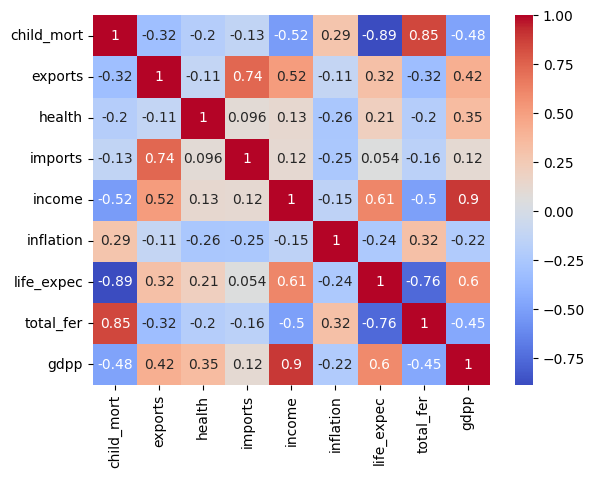

In [11]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap

corr_matrix = country_df.corr()

sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')

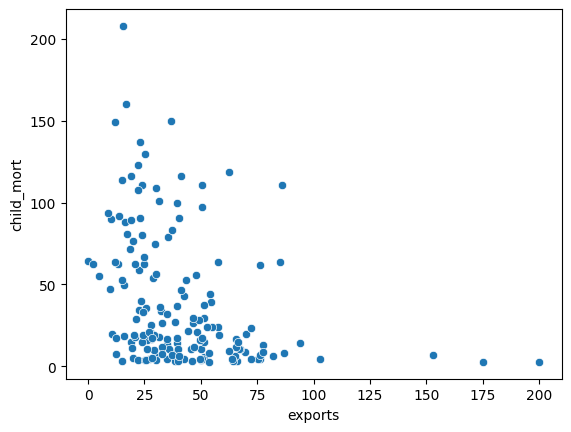

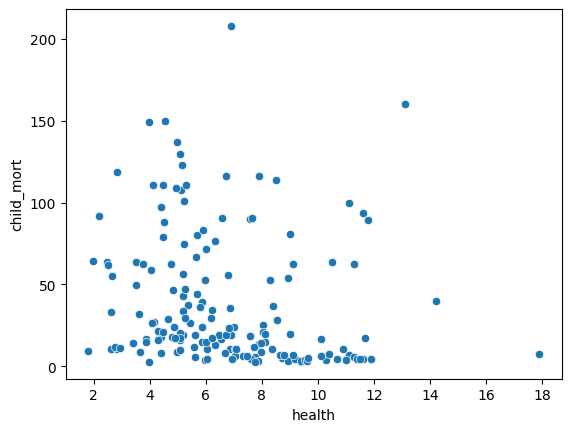

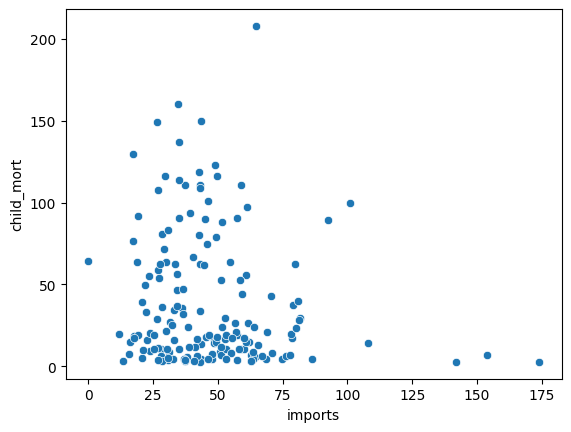

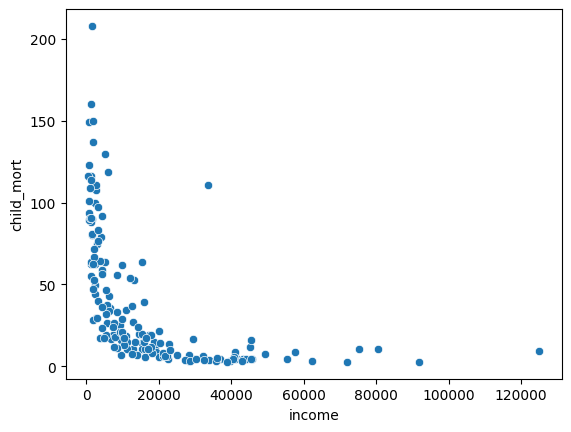

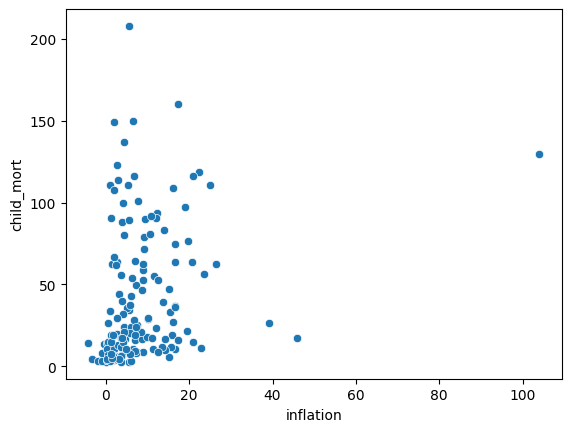

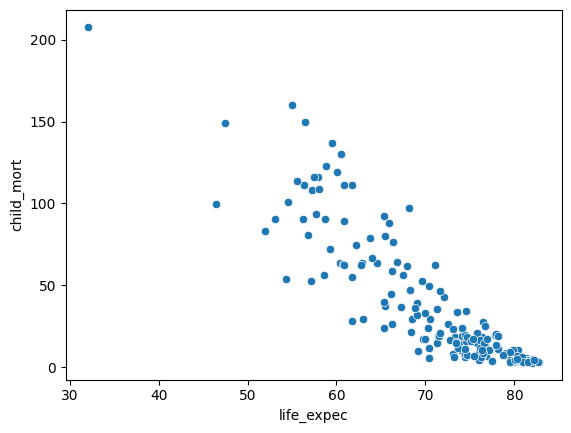

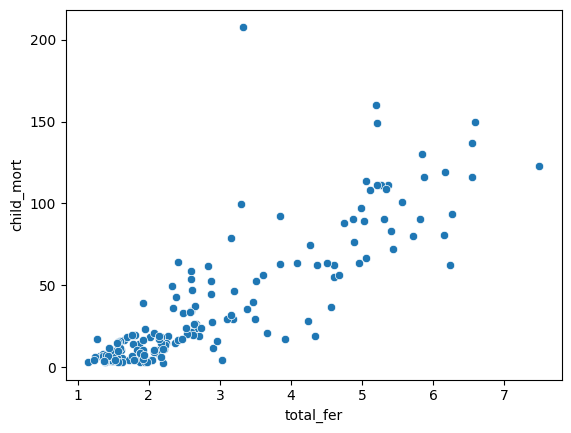

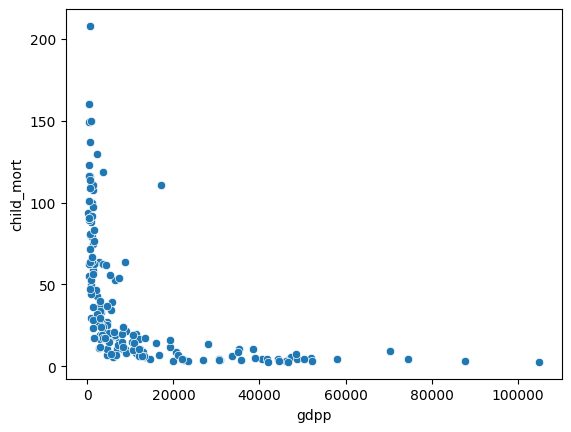

In [12]:
# Explore the continuous independent features against child_mort using scatter plots.

features = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

for i in features:
    plt.figure()
    sns.scatterplot(data=country_df,x=i,y='child_mort')
    plt.show()

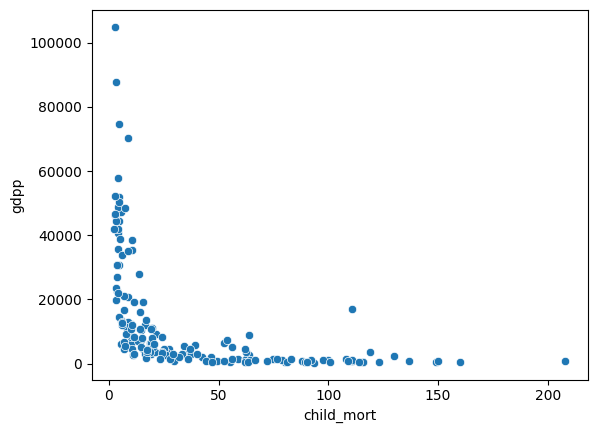

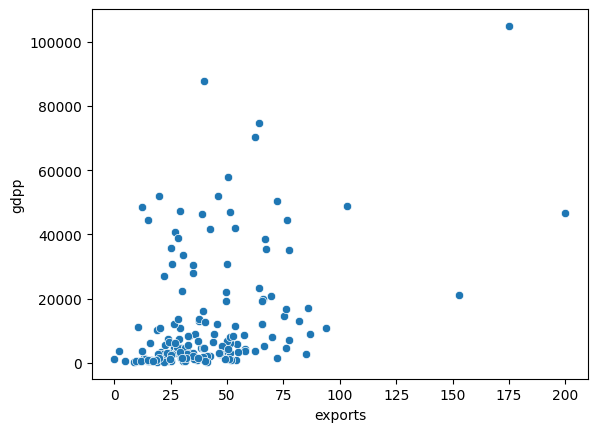

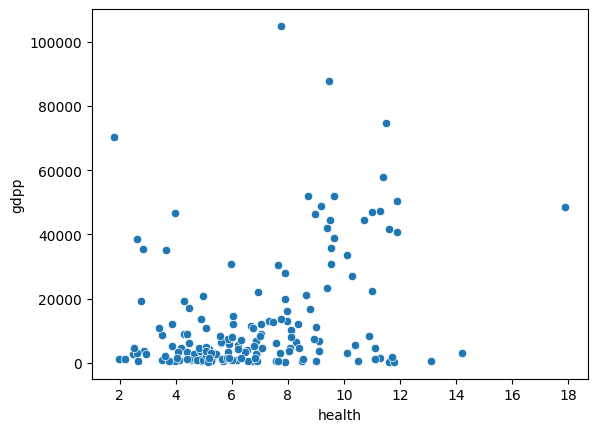

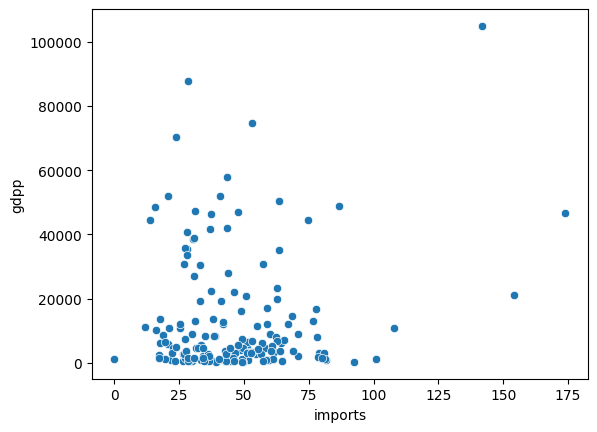

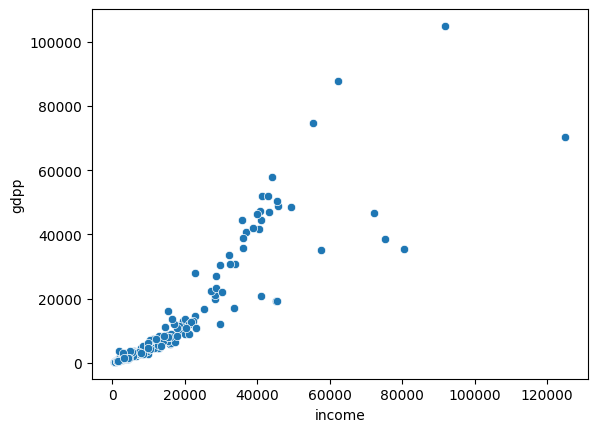

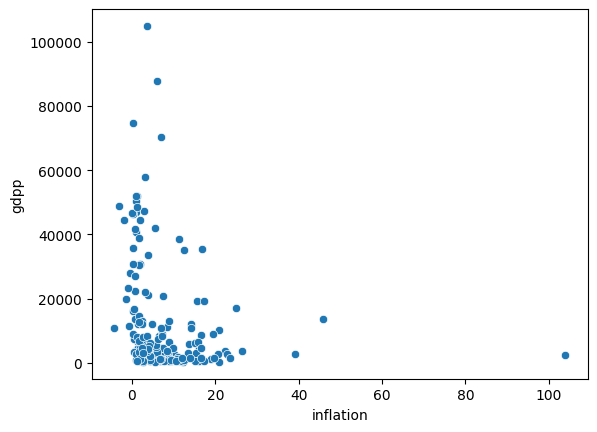

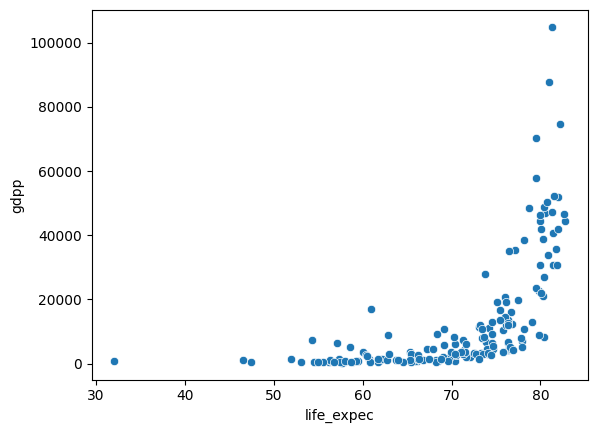

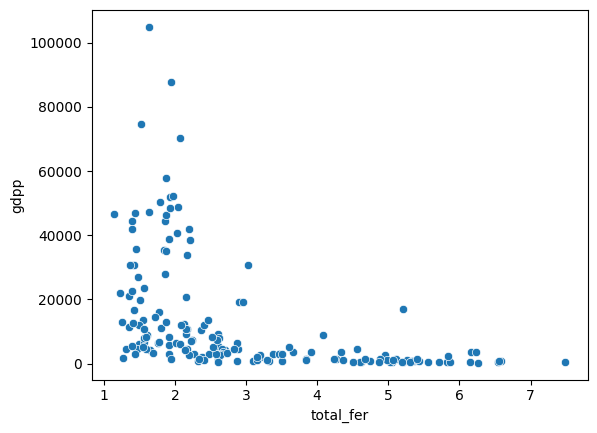

In [13]:
# Explore the continuous independent features against gdpp using scatter plots.

features = country_df.drop(columns=["gdpp"])

for i in features:
    plt.figure()
    sns.scatterplot(data=country_df,x=i,y='gdpp')
    plt.show()

#Looking at the graphs , the GDPP and Life expectancy graph looks the most promising
    

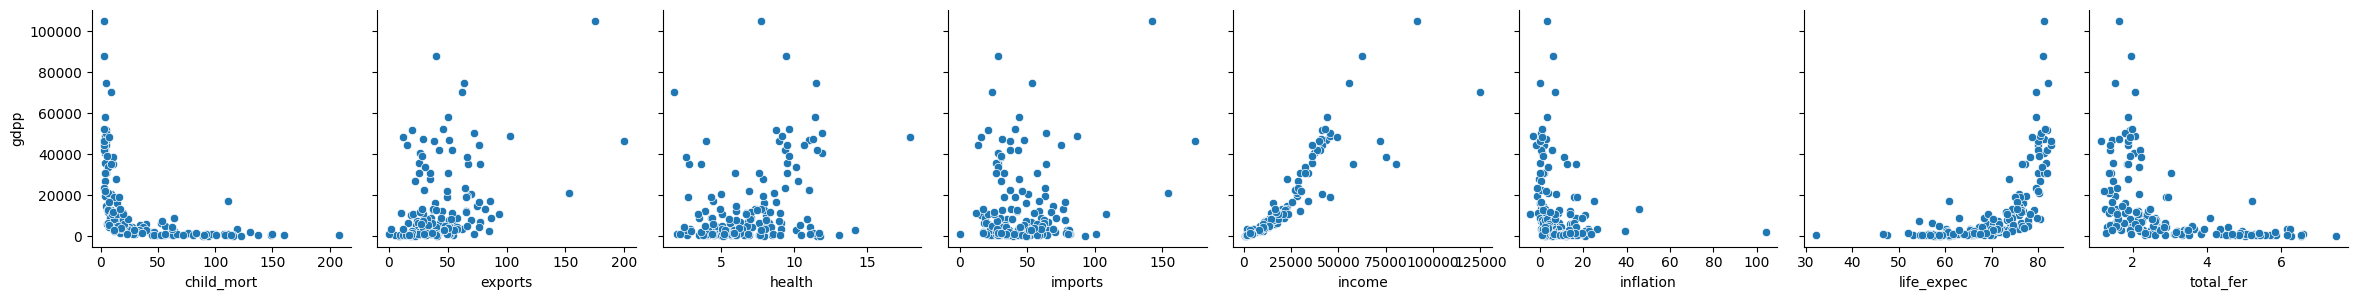

In [14]:
# Create a pair plot
# Hint: Explore seaborn pairplot

features = country_df.drop(columns=["gdpp"])

sns.pairplot(data=country_df,x_vars=features,y_vars=['gdpp'], height=3, aspect=1, kind="scatter")
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [15]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

scaler = MinMaxScaler()
country_df = pd.read_csv("Country-data.csv")

features = ['child_mort','exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

df_scaled = pd.DataFrame(scaler.fit_transform(country_df[features]),columns=features)

df_scaled.insert(0,'country',country_df['country'])

print(df_scaled)
# df_scaled.head()

                 country  child_mort   exports    health   imports    income  \
0            Afghanistan    0.426485  0.049482  0.358608  0.257765  0.008047   
1                Albania    0.068160  0.139531  0.294593  0.279037  0.074933   
2                Algeria    0.120253  0.191559  0.146675  0.180149  0.098809   
3                 Angola    0.566699  0.311125  0.064636  0.246266  0.042535   
4    Antigua and Barbuda    0.037488  0.227079  0.262275  0.338255  0.148652   
..                   ...         ...       ...       ...       ...       ...   
162              Vanuatu    0.129503  0.232582  0.213797  0.302609  0.018820   
163            Venezuela    0.070594  0.142032  0.192666  0.100809  0.127750   
164              Vietnam    0.100779  0.359651  0.312617  0.460715  0.031200   
165                Yemen    0.261441  0.149536  0.209447  0.197397  0.031120   
166               Zambia    0.391918  0.184556  0.253574  0.177275  0.021473   

     inflation  life_expec  total_fer  

## K-Means Clustering

### Selecting K

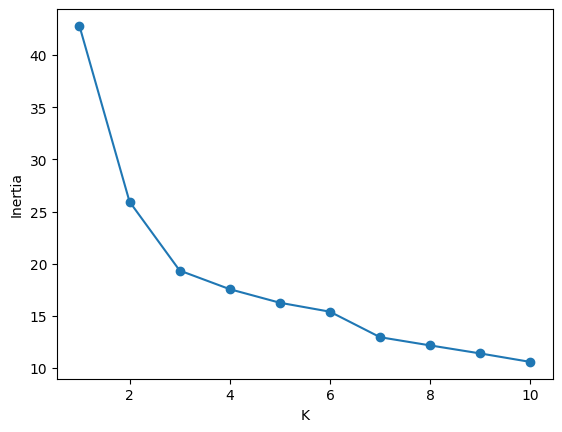

In [16]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset

df_scaled = df_scaled.drop(columns=["country"])
elbow_Kmeans(df_scaled)

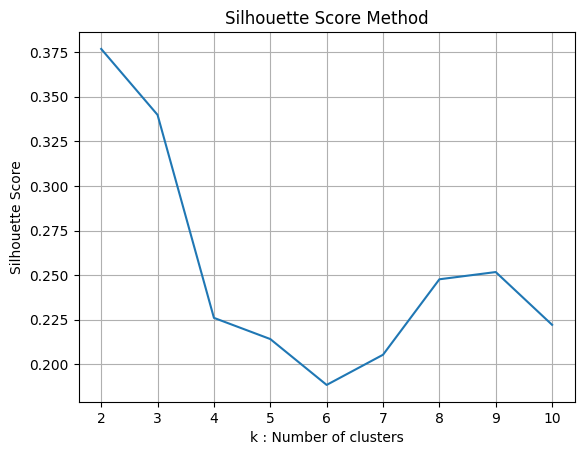

In [17]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
rseed = 42
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [18]:
# Remember to set the random_state to rseed
random_state = rseed

In [19]:
# Count the number of records in each cluster
k_values = range(2, 11)
optimal_k = k_values[np.argmax(sil)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

print(df_scaled['Cluster'].value_counts().sort_index())

#Looking at the graphs the optimal number of clusters are 4

Cluster
0    116
1     51
Name: count, dtype: int64


In [20]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

Silhouette Score: 0.623


## Predictions

In [21]:
# Add the predicted cluster label column to the original dataframe

country_df['pred_cluster'] = kmeans.fit_predict(df_scaled)

## Visualisation of clusters

<Axes: xlabel='gdpp', ylabel='child_mort'>

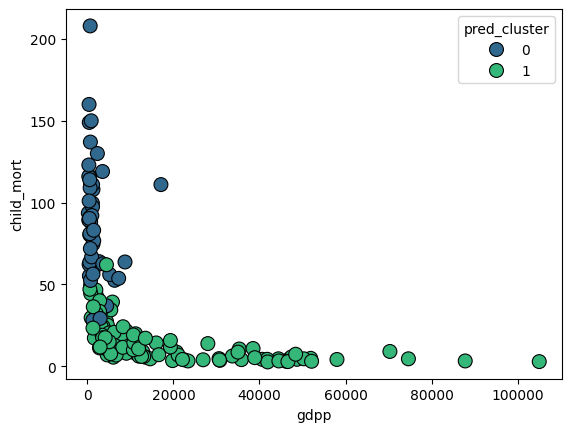

In [22]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(data=country_df, x='gdpp', y='child_mort', hue='pred_cluster', palette='viridis', s=100, edgecolor='black')

<Axes: xlabel='gdpp', ylabel='inflation'>

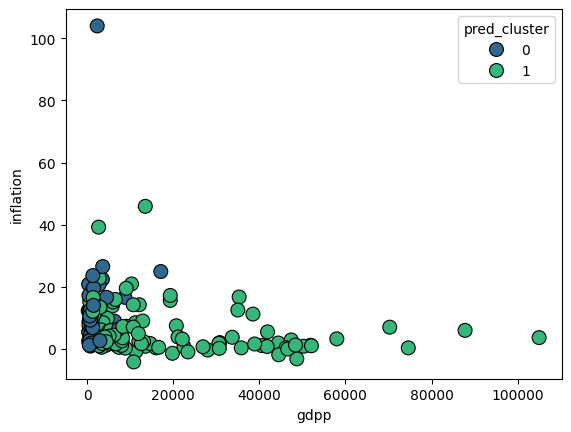

In [23]:
# Visualisation of clusters: inflation vs gdpp
sns.scatterplot(data=country_df, x='gdpp', y='inflation', hue='pred_cluster', palette='viridis', s=100, edgecolor='black')

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

In [25]:
features = ['child_mort', 'gdpp', 'inflation']

df_centroids = country_df.groupby('country')[features].mean().sort_values('gdpp', ascending=False)
print(df_centroids)

                  child_mort      gdpp  inflation
country                                          
Luxembourg               2.8  105000.0      3.620
Norway                   3.2   87800.0      5.950
Switzerland              4.5   74600.0      0.317
Qatar                    9.0   70300.0      6.980
Denmark                  4.1   58000.0      3.220
...                      ...       ...        ...
Sierra Leone           160.0     399.0     17.200
Niger                  123.0     348.0      2.550
Congo, Dem. Rep.       116.0     334.0     20.800
Liberia                 89.3     327.0      5.470
Burundi                 93.6     231.0     12.300

[167 rows x 3 columns]
